In [1]:
import os
import cv2
import pickle
import numpy as np
from PIL import Image

In [2]:
pre_seq_length = 11 # x-frames
aft_seq_length = 11 # y-frames (to predict)

In [3]:
folder_path = "../sample_data/train"
print(os.listdir(folder_path))

np.array(Image.open("../sample_data/train/video_0/image_21.png")).shape

['video_1', 'video_3', '.DS_Store', 'video_2', 'video_0']


(160, 240, 3)

In [4]:
def read_data(folder_path):
    all_frames = []
    videos = os.listdir(folder_path)

    for folder in videos: # video_i/
        if folder == ".DS_Store":
            continue

        video_frames = []
        for i in range(22):
            frame_path = os.path.join(folder_path, folder, f"image_{i}.png")
            frame = np.array(Image.open(frame_path))
            video_frames.append(frame)
        video_frames = np.stack(video_frames)
        all_frames.append(video_frames)

    data = np.stack(all_frames).transpose(0,1,4,2,3) # (N,T,C,H,W)

    # Rescale [0,255] into [0,1]
    if data.max() > 1.0:
        data = data.astype(np.float32) / 255.0
    return data[:, :11], data[:, 11:] # (4, 22, 3, 160, 240)

In [5]:
dataset = {}
folders = ['train', 'val']

for folder in folders:
    data_x, data_y = read_data(os.path.join("../sample_data/", folder))
    dataset['X_' + folder], dataset['Y_' + folder] = data_x, data_y

# save as a pkl file
with open('dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

### Load the dataset and visualize an example

In [6]:
# load the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

train_x, train_y = dataset['X_train'], dataset['Y_train']
print(train_x.shape)

(4, 11, 3, 160, 240)


/home/sn3250/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


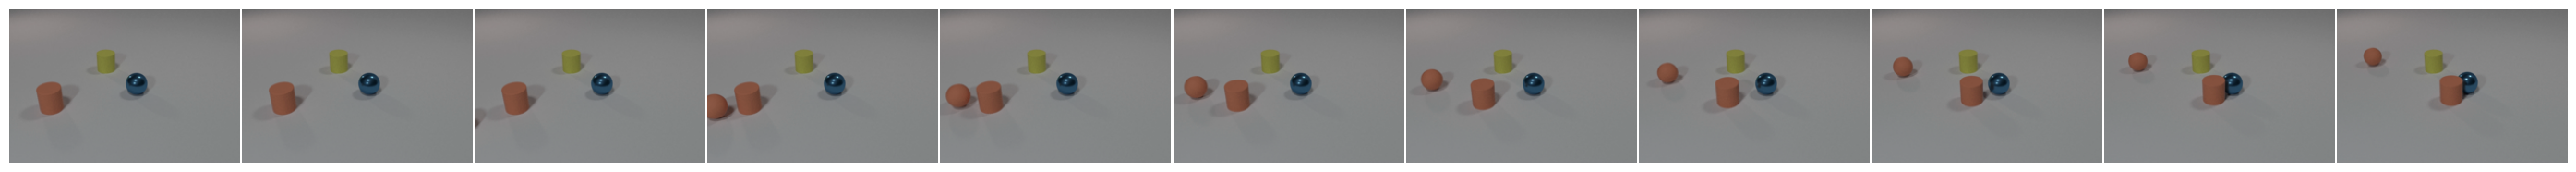

In [7]:
from openstl.utils import show_video_line

# show the given frames from an example
example_idx = 2
show_video_line(train_x[example_idx], ncols=pre_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

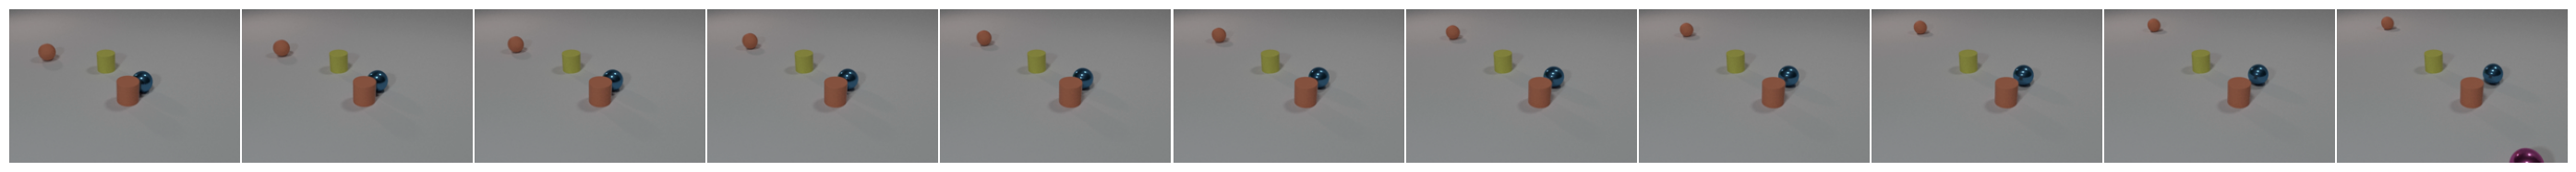

In [8]:
# show the future frames from an example
example_idx = 2
show_video_line(train_y[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

## 2. Utilize custom data

### 2.1 Define the dataset

We first define the `CustomDataset` to use the provided dataset.

For real video prediction, to facilitate model optimization, we strongly recommend users to use frames represented as `float32` with values in the range of $[0, 1]$, rather than frames represented as `uint8` with values in the range of $[0, 255]$. For other types of data, we also provide the option to `normalize` in the `CustomDataset`.

In [9]:
import torch
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, Y, normalize=False):
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.mean = None
        self.std = None

        if normalize:
            # get the mean/std values along the channel dimension
            mean = data.mean(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            std = data.std(axis=(0, 1, 2, 3)).reshape(1, 1, -1, 1, 1)
            data = (data - mean) / std
            self.mean = mean
            self.std = std

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        data = torch.tensor(self.X[index]).float()
        labels = torch.tensor(self.Y[index]).float()
        return data, labels

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [10]:
batch_size = 1

In [11]:
X_train, X_val, Y_train, Y_val = dataset['X_train'], dataset['X_val'], dataset['Y_train'], dataset['Y_val']

train_set = CustomDataset(X=X_train, Y=Y_train)
val_set = CustomDataset(X=X_val, Y=Y_val)

In [12]:
dataloader_train = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_val = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=True, pin_memory=True)

In [13]:
# next(iter(dataloader_train))

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

### SimVP

In [14]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [11, 3, 160, 240], # (T,C,H,W)
}

# ---------- https://github.com/chengtan9907/OpenSTL/tree/master/configs
custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256,


    "sched": "onecycle" # <Adding to prevent code fail> -- onecycle, cosine, tanh, step, multistep
}

### DMVFN

In [15]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    #'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    #'lr': 0.001,
    'metrics': ['mse', 'mae'],
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [11, 3, 160, 240], # (T,C,H,W)
}

# ---------- https://github.com/chengtan9907/OpenSTL/tree/master/configs
custom_model_config = {
    'method': 'DMVFN',
    'config_file': 'configs/kth/DMVFN.py',
     "routing_out_channels": 32,
      "in_planes": 4 * 1 + 1 + 4, # the first 1: data channel, the second 1: mask channel, the third 4: flow channel
      "num_block": 9,
      "num_features": [160, 160, 160, 80, 80, 80, 44, 44, 44],
      "scale": [4, 4, 4, 2, 2, 2, 1, 1, 1],
      "training": True,
      "beta": 0.5,
      "gamma": 0.8,
      "coef": 0.5,
      # training,
      "lr": 5e-5,
      "batch_size": 16,
      "sched": 'onecycle'
}

### TAU

In [16]:
custom_model_config = {"method": 'TAU',
                       "config_file": 'x',
                    # model
                    "spatio_kernel_enc": 3,
                    "spatio_kernel_dec": 3,
                    "model_type": 'tau',
                    "hid_S": 64,
                    "hid_T": 512,
                    "N_T": 8,
                    "N_S": 4,
                    "alpha": 0.1,
                    # training
                    "lr": 1e-3,
                    "batch_size": 16,
                    "drop_path": 0,
                    "sched": 'onecycle'
                      }

### PredRNNv2

In [17]:
custom_model_config = {
                    "method": 'PredRNNv2',
                    # reverse scheduled sampling
                    "reverse_scheduled_sampling": 1,
                    "r_sampling_step_1": 25000,
                    "r_sampling_step_2": 50000,
                    "r_exp_alpha": 5000,
                    # scheduled sampling
                    "scheduled_sampling": 1,
                    "sampling_stop_iter": 50000,
                    "sampling_start_value": 1.0,
                    "sampling_changing_rate": 0.00002,
                    # model
                    "num_hidden": '128,128,128,128',
                    "filter_size": 5,
                    "stride": 1,
                    "patch_size": 4,
                    "layer_norm": 0,
                    "decouple_beta": 0.1,
                    # training
                    "lr": 5e-4,
                    "batch_size": 16,
                    "sched": 'onecycle'
                }

### SimVP with Swin Transformer
https://github.com/chengtan9907/OpenSTL/blob/master/configs/mmnist/simvp/SimVP_Swin.py

In [18]:
custom_model_config = {
                    "method": 'SimVP',
                    # model
                    "spatio_kernel_enc": 3,
                    "spatio_kernel_dec": 3,
                    "model_type": 'swin',
                    "hid_S": 64,
                    "hid_T": 512,
                    "N_T": 8,
                    "N_S": 4,
                    # training
                    "lr": 1e-3,
                    "batch_size": 16,
                    "drop_path": 0,
                    "sched": 'onecycle'
                    }

### SimVP with ViT

In [19]:
custom_model_config = {
                    "method": 'SimVP',
                    # model
                    "spatio_kernel_enc": 3,
                    "spatio_kernel_dec": 3,
                    "model_type": 'vit',
                    "hid_S": 64,
                    "hid_T": 512,
                    "N_T": 8,
                    "N_S": 4,
                    # training
                    "lr": 1e-3,
                    "batch_size": 16,
                    "drop_path": 0,
                    "sched": 'onecycle'
                    }

In [20]:
## https://github.com/chengtan9907/OpenSTL/blob/master/tools/train.py#L33C1-L33C1

# from openstl.utils import load_config, update_config, create_parser, default_parser

# dataname = "kth" #mmnist
# method = "DMVFN" #


# args = create_parser().parse_args([])
# config = args.__dict__

# cfg_path = os.path.join('./configs', dataname, f'{method}.py')
# config = update_config(config, load_config(cfg_path), exclude_keys=['method'])

# default_values = default_parser()
# for attribute in default_values.keys():
#     if config[attribute] is None:
#         config[attribute] = default_values[attribute]

# args

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`.

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [21]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)

# update the model config
config.update(custom_model_config)

config # 'config_file': 'configs/mmnist/simvp/SimVP_gSTA.py'

{'device': 'cuda',
 'dist': False,
 'display_step': 10,
 'res_dir': 'work_dirs',
 'ex_name': 'custom_exp',
 'use_gpu': True,
 'fp16': False,
 'torchscript': False,
 'seed': 42,
 'diff_seed': False,
 'fps': False,
 'empty_cache': True,
 'find_unused_parameters': False,
 'broadcast_buffers': True,
 'resume_from': None,
 'auto_resume': False,
 'test': False,
 'inference': False,
 'deterministic': False,
 'launcher': 'none',
 'local_rank': 0,
 'port': 29500,
 'batch_size': 16,
 'val_batch_size': 1,
 'num_workers': 4,
 'data_root': './data',
 'dataname': 'custom',
 'pre_seq_length': 11,
 'aft_seq_length': 11,
 'total_length': 22,
 'use_augment': False,
 'use_prefetcher': False,
 'drop_last': False,
 'method': 'SimVP',
 'config_file': 'configs/mmnist/simvp/SimVP_gSTA.py',
 'model_type': 'vit',
 'drop': 0.0,
 'drop_path': 0,
 'overwrite': False,
 'epoch': 3,
 'log_step': 1,
 'opt': 'adam',
 'opt_eps': None,
 'opt_betas': None,
 'momentum': 0.9,
 'weight_decay': 0.0,
 'clip_grad': None,
 'clip

In [22]:
args

Namespace(device='cuda', dist=False, display_step=10, res_dir='work_dirs', ex_name='custom_exp', use_gpu=True, fp16=False, torchscript=False, seed=42, diff_seed=False, fps=False, empty_cache=True, find_unused_parameters=False, broadcast_buffers=True, resume_from=None, auto_resume=False, test=False, inference=False, deterministic=False, launcher='none', local_rank=0, port=29500, batch_size=16, val_batch_size=1, num_workers=4, data_root='./data', dataname='custom', pre_seq_length=11, aft_seq_length=11, total_length=22, use_augment=False, use_prefetcher=False, drop_last=False, method='SimVP', config_file='configs/mmnist/simvp/SimVP_gSTA.py', model_type='vit', drop=0.0, drop_path=0, overwrite=False, epoch=3, log_step=1, opt='adam', opt_eps=None, opt_betas=None, momentum=0.9, weight_decay=0.0, clip_grad=None, clip_mode='norm', early_stop_epoch=-1, no_display_method_info=False, sched='onecycle', lr=0.001, lr_k_decay=1.0, warmup_lr=1e-05, min_lr=1e-06, final_div_factor=10000.0, warmup_epoch=0

In [23]:
exp = BaseExperiment(args, config, dataloaders=(dataloader_train, dataloader_val, dataloader_val)) # Needs test dataloader

Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.8.r11.8/compiler.31833905_0
GPU 0: Quadro RTX 8000
GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
PyTorch: 2.1.1+cu118
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=

### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation.

Here we go!

In [24]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


train loss: 0.0518 | data time: 0.0165: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]

[>>>>>>>>                          ] 1/4, 11.8 task/s, elapsed: 0s, ETA:     0s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 10.5 task/s, elapsed: 0s, ETA:     0sval	 mse:2064.25048828125, mae:12227.4697265625
[2023-11-20 02:38:33] Intermediate result: 2064.2505  (Index 0)
Epoch: 1, Steps: 4 | Lr: 0.0009330 | Train Loss: 0.0564923 | Vali Loss: 0.0179188

Validation loss decreased (inf --> 0.017919).  Saving model ...


train loss: 0.0095 | data time: 0.0089: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

[>>>>>>>>                          ] 1/4, 12.0 task/s, elapsed: 0s, ETA:     0s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 10.6 task/s, elapsed: 0s, ETA:     0sval	 mse:1161.7550048828125, mae:8845.416015625
[2023-11-20 02:38:35] Intermediate result: 1161.755  (Index 1)
Epoch: 2, Steps: 4 | Lr: 0.0002831 | Train Loss: 0.0133851 | Vali Loss: 0.0100847

Validation loss decreased (0.017919 --> 0.010085).  Saving model ...


train loss: 0.0085 | data time: 0.0089: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s]

[>>>>>>>>                          ] 1/4, 11.8 task/s, elapsed: 0s, ETA:     0s

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 10.4 task/s, elapsed: 0s, ETA:     0sval	 mse:964.4713745117188, mae:7683.4970703125
[2023-11-20 02:38:36] Intermediate result: 964.4714  (Index 2)
Epoch: 3, Steps: 4 | Lr: 0.0000346 | Train Loss: 0.0085409 | Vali Loss: 0.0083721

Validation loss decreased (0.010085 --> 0.008372).  Saving model ...


In [25]:
print('>'*35 + ' testing  ' + '<'*35)
exp.test() # Model saved in -- OpenSTL/work_dirs/custom_exp/checkpoints

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 4/4, 11.4 task/s, elapsed: 0s, ETA:     0s

------------------
{'mse': 964.47144, 'mae': 7683.4976}
{'test_mse': 964.47144, 'test_mae': 7683.4976}
mse:964.471435546875, mae:7683.49755859375


964.47144

## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

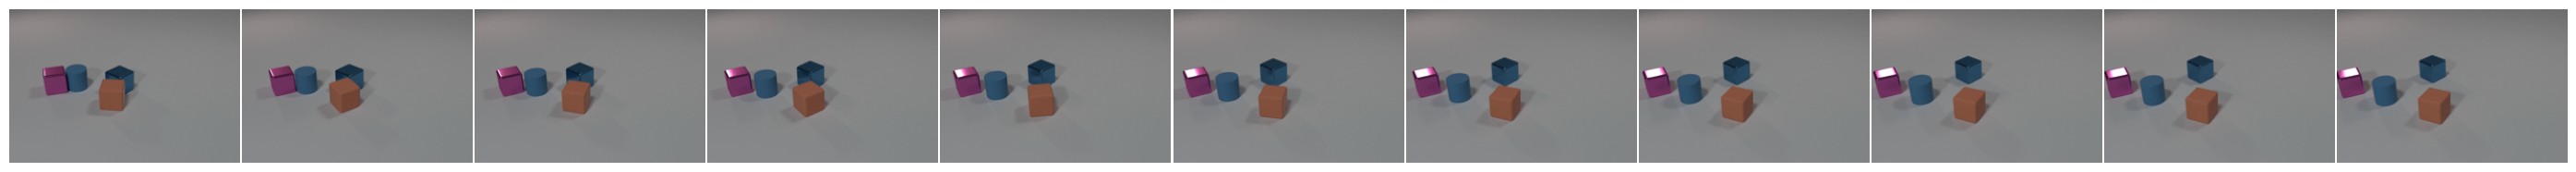

In [26]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

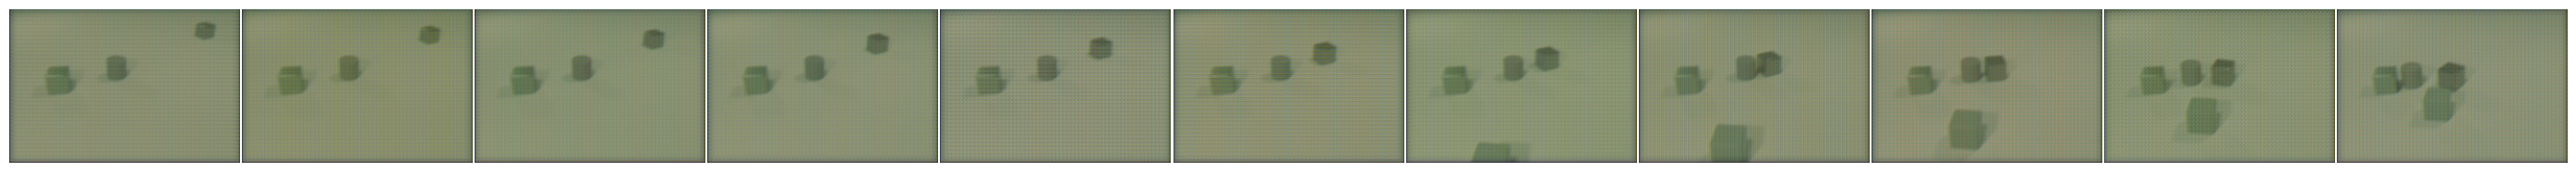

In [27]:
example_idx = 0
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

### 4.2 Generate a GIF

/scratch/sn3250/DL/project/OpenSTL/openstl/utils/visualization.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))


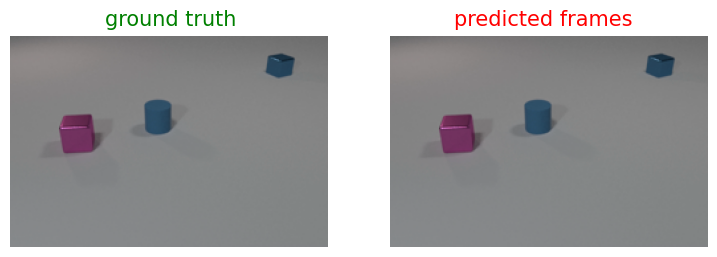

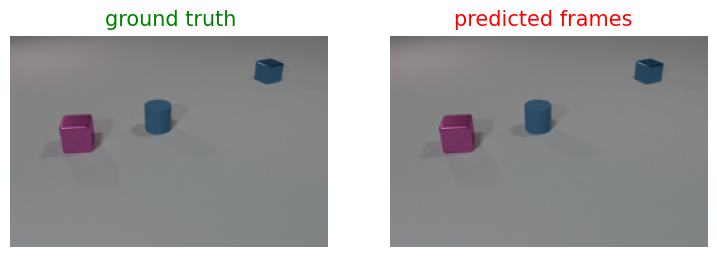

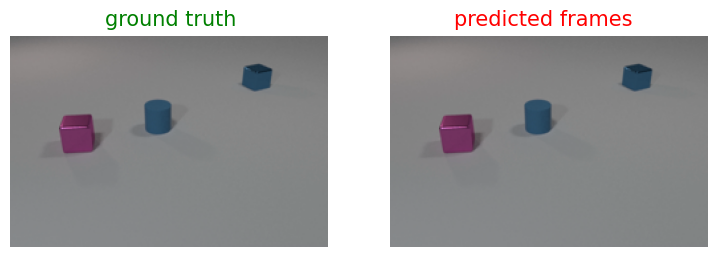

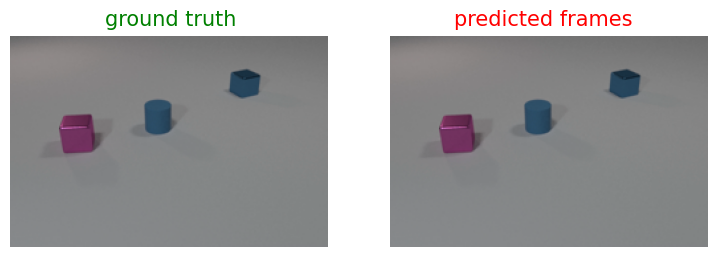

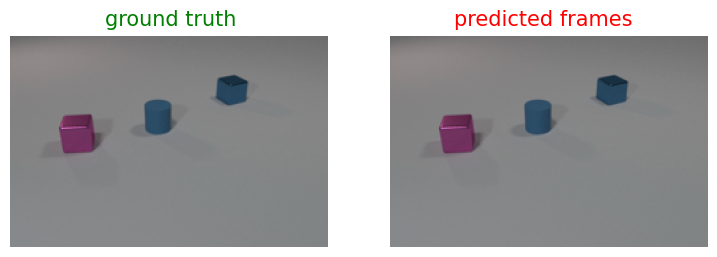

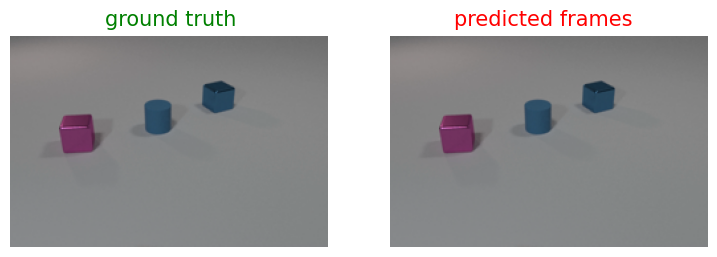

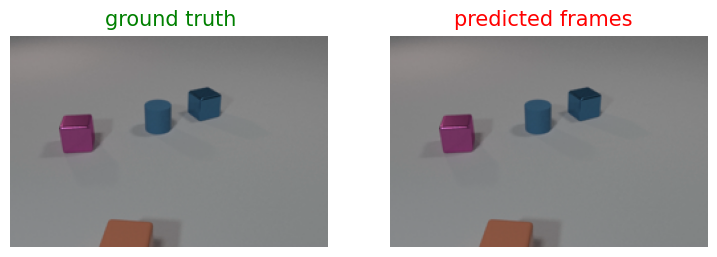

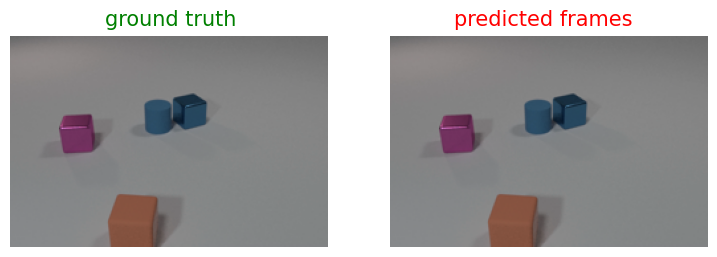

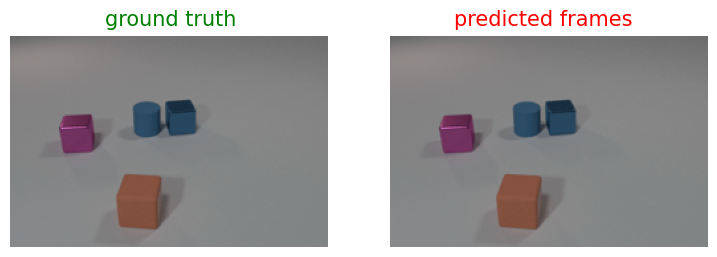

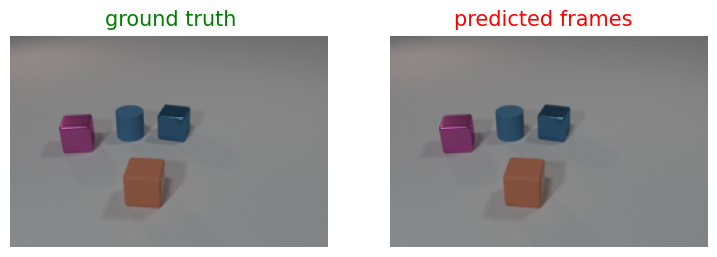

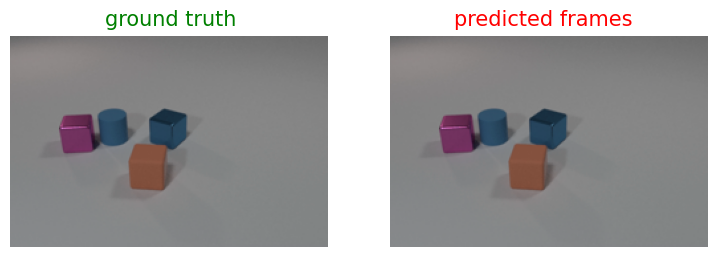

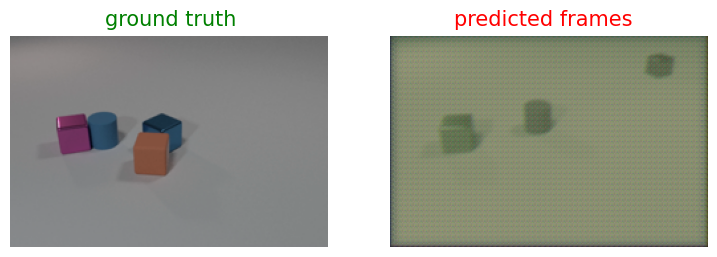

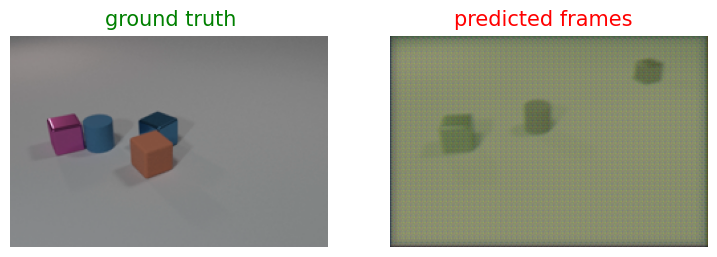

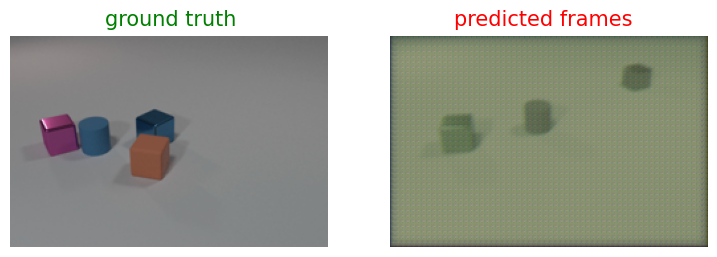

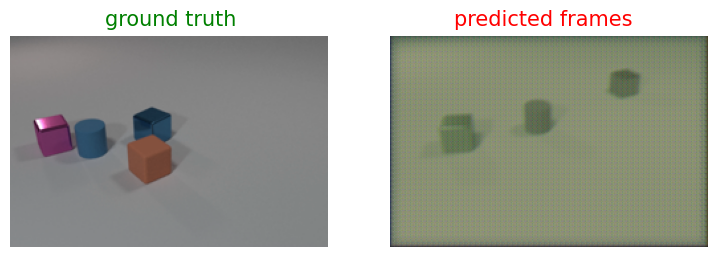

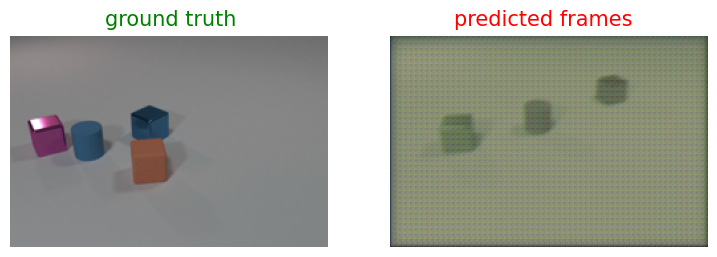

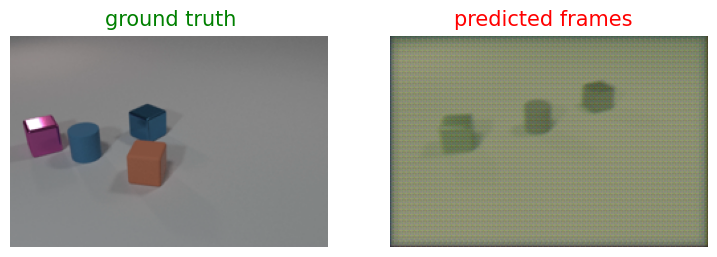

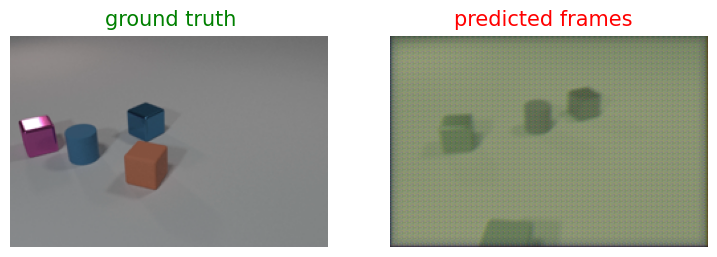

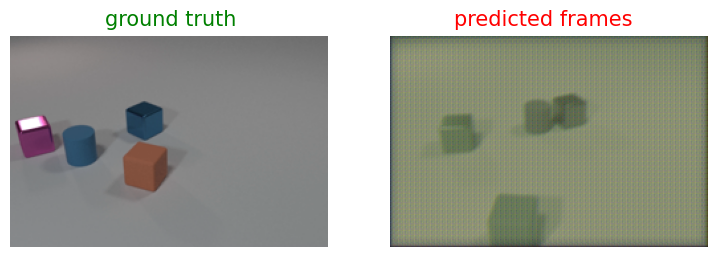

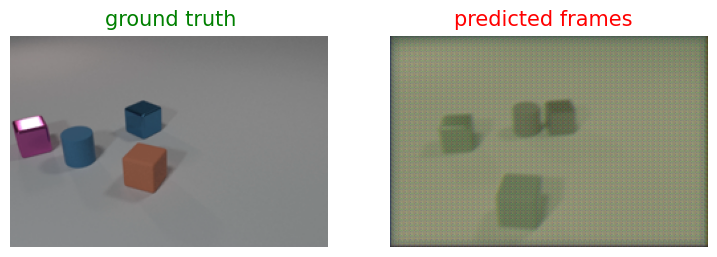

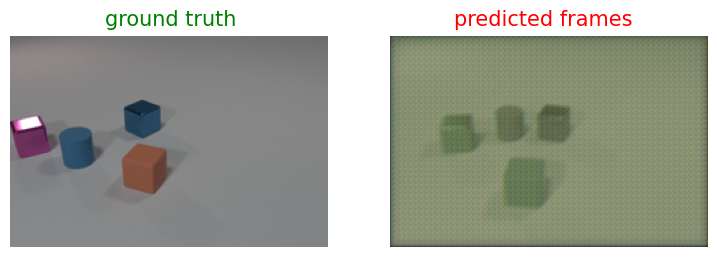

In [28]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')

## Viz single pred

In [29]:
import matplotlib.pyplot as plt

In [30]:
preds.shape

(4, 11, 3, 160, 240)

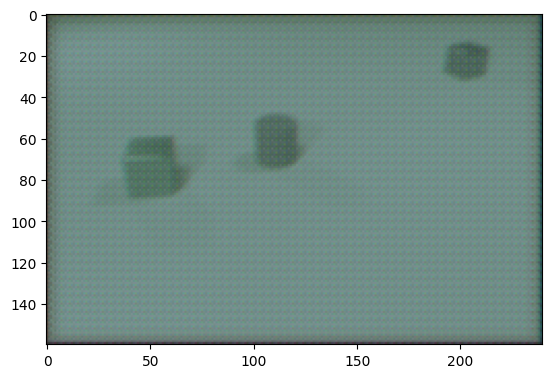

In [31]:
plt.imshow(preds[0,0].transpose(1,2,0))

In [32]:
# img_n = cv2.normalize(src=preds[0,0].transpose(1,2,0), dst=None, alpha=0, beta=255, 
#                       norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# plt.imshow(img_n)